In [1]:
import collections

class PI:
    
    PI_dict = collections.defaultdict()
    proj_dict = collections.defaultdict(str)
    def __init__(self, **kwargs):
        self.name = kwargs.get('name', '')
        self.dept = kwargs.get('dept', [])
        self.proj = kwargs.get('proj', [])
        # updating proj_list
        PI.update_proj_dict(self)
        
        # updating PI_list
        PI.update_PI_dict(self)
        
    
    def __repr__(self):
        return 'PI: {} '.format(self.name) + ','.join(self.dept) + ' ' + ','.join(self.proj)
    
    def add_dept(self, s):
        self.dept.append(s)
        
    def add_proj(self, s):
        self.proj.append(s)
        
    def update_proj_dict(self):
        for p in self.proj:               
            if p not in PI.proj_dict.keys():
                PI.proj_dict[p] = self.name
            else:
                pass
            
    def update_PI_dict(self):
        if self.name not in PI.PI_dict.keys():
            PI.PI_dict[self.name] = self
        else:
            for p in self.proj:
                if p not in PI.PI_dict[self.name].proj:
                    PI.PI_dict[self.name].add_proj(p)
                else:
                    pass
            for dept in self.dept:
                if dept not in PI.PI_dict[self.name].dept:
                    PI.PI_dict[self.name].add_dept(dept)
                else:
                    pass
    
    @classmethod
    def get_PI_dict(cls):
        return cls.PI_dict
    
    @classmethod
    def get_proj_dict(cls):
        return cls.proj_dict

LuiSha = PI(name='Lui Sha',dept=['CS','CSL'],proj=['2016-08-100-02'])
RomitChoudhury = PI(name='Romit Roy Choudhury',dept=['ECE','CSL'],proj=['2017-06-100-01'])
SayanMitra = PI(name='Sayan Mitra',dept=['ECE','CSL'],proj=['2016-06-103-01'])
GirishKrishnan = PI(name='Girish Krishnan',dept=['ISE','CSL'],proj=['2017-03-106-01'])
SethHutchinson = PI(name='Seth Hutchinson', dept=['ECE', 'CSL'],proj=['2016-10-103-02', '2016-10-103-01'])
GraceGao = PI(name='Grace Gao', dept=['AE', 'CSL'], proj=['2016-11-103-01'])
MinhDo = PI(name='Minh Do', dept=['ECE', 'CSL'], proj=['2016-11-103-02'])
TimBretl = PI(name='Timothy Bretl', dept=['AE', 'CSL'], proj=['2017-02-103-02'])
MichaelSelig = PI(name='Michael Selig', dept=['AE'], proj=['2017-02-102-01'])
HwPark = PI(name='Hae-Won Park', dept=['ME', 'CSL'], proj=['2017-02-101-01'])
AimyWissa = PI(name='Aimy Wissa', dept=['ME'], proj=['2017-04-101-01'])
SayanMitra = PI(name='Sayan Mitra', dept=['ECE', 'CSL'], proj=['2017-03-103-01'])
PhilipAnsell = PI(name='Philip Ansell', dept=['AE'], proj=['2017-01-102-01'])
RomitRoyChoudhury = PI(name='Romit Roy Choudhury', dept=['ECE', 'CSL'], proj=['2016-08-100-01', '2017-02-100-01'])
GirishChowdhary = PI(name='Girish Chowdhary', dept=['ABE', 'CSL'], proj=['2016-11-105-01', '2016-10-105-01'])
AmyLaViers = PI(name='Amy LaViers', dept=['ME'], proj=['2016-12-101-01'])
NairaHovakimyan = PI(name='Naira Hovakimyan', dept=['ME','AE', 'CSL'], proj=['2016-08-101-01'])
PaulKwiat = PI(name='Paul G Kwiat', dept=['PHYS', 'ECE'], proj=['2016-08-104-01'])
DanWork = PI(name='Dan Work', dept=['CEE', 'CSL'], proj=['2017-06-107-01'])

In [16]:
import datetime, dateutil.parser

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xlsxwriter

from dateutil.relativedelta import relativedelta
from oauth2client import client
from googleapiclient import sample_tools

proj_to_PI = PI.get_proj_dict()
PI_dict = PI.get_PI_dict()

def crawl(start_date = datetime.date(2016,7,1), end_date = datetime.date.today()):
    # Authenticate and construct service.
    service, flags = sample_tools.init(
        ' ', 'calendar', 'v3', ' ', ' ',
        scope='https://www.googleapis.com/auth/calendar.readonly')
    page_token = None
    
    projs = {}
    days = {}
    
    while True:
        events = service.events().list(calendarId='irl1.uiuc@gmail.com', pageToken=page_token).execute()
        for event in events['items']:
            if 'start' in event.keys():
                e_date_str = event['start']['dateTime']
                e_date_str = e_date_str.split('T')[0].split('-')

                e_date = datetime.date(int(e_date_str[0]), int(e_date_str[1]), int(e_date_str[2]))
                                   
                if e_date >= start_date and e_date < end_date:
                    items = event.items()
                    for key, value in items:
                        if key == 'description':
                            pieces = value.split('PROJ:')
                            pieces = pieces[-1].split('\n')
                            num = pieces[0].strip()
                            if num[:3] == '201': # 2016, 2017, 201x
                                deltaTime = dateutil.parser.parse(event['end']['dateTime']) - dateutil.parser.parse(event['start']['dateTime'])
                                time_h = deltaTime.seconds/3600
                                
                                # add to proj-time
                                if num in projs.keys():                                    
                                    projs[num] += time_h
                                else:
                                    projs[num] = time_h
                                
                                # add to day-time
                                days_date = dateutil.parser.parse(event['start']['dateTime'])
                                days_key = str(days_date).split(' ')[0]
                                
                                if days_key in days.keys():
                                    days[days_key] += time_h
                                else:
                                    days[days_key] = time_h
                                
                    
        page_token = events.get('nextPageToken')
        if not page_token:
            break
            
    return projs, days

def fetch_range(start_date = datetime.date(2016,7,1), end_date = datetime.date.today()):
    return crawl(start_date, end_date)

def fetch_month(year = datetime.datetime.now().year, month = datetime.datetime.now().month):
    start_date = datetime.date(year,month,1)
    end_date = start_date + relativedelta(months = +1)
    return crawl(start_date, end_date)

def get_PI_dept_hours_from_proj_hours(proj_hours):
    PI_hours = {}
    dept_hours = {}
    
    for key, value in proj_hours.items():
        if key not in proj_to_PI.keys():
            raise RuntimeError("unknown project number from PI database, key = {}".format(key))
        
        name = proj_to_PI[key]
    
        if name not in PI_hours.keys():
            PI_hours[name] = value
        else:
            PI_hours[name] += value
    
        d = PI_dict[name].dept
    
        for i in d:
            if i not in dept_hours.keys():
                dept_hours[i] = value
            else:
                dept_hours[i] += value

    return PI_hours, dept_hours


def report_range(start_year=2016, start_month=8, start_day=1, 
                 end_year=datetime.date.today().year, 
                 end_month=datetime.date.today().month, 
                 end_day=datetime.date.today().day):
    
    start_date = datetime.date(start_year, start_month, start_day)
    end_date = datetime.date(end_year, end_month, end_day)
    projs, days = fetch_range(start_date, end_date)

    # figure title
    title = ''
    if end_date <= start_date + relativedelta(months = +1):
        title = '{}-{}'.format(start_date.year, start_date.month)  
    else:
        title = '{} to {}'.format(start_date, end_date)
    print(title)
    writer = pd.ExcelWriter('./output/{}.xlsx'.format(title), engine='xlsxwriter')

    proj_hours, _ = fetch_range(start_date, end_date)
    pi_hours, dept_hours = get_PI_dept_hours_from_proj_hours(proj_hours)

    pi_df = pd.DataFrame(list(pi_hours.items()))
    pi_df.columns = ['name', 'hours']
    pi_df['percentage'] = 100 * pi_df['hours'] / pi_df['hours'].sum()
    pi_df = pi_df.sort_values('hours', ascending=False)
    pi_df.reset_index(drop=True, inplace=True)

    dept_list = []
    for index, row in pi_df.iterrows():
        key = row['name']
        dept = PI_dict[key].dept
        dept_list.append(dept)

    pi_df['dept'] = pd.Series(dept_list)

    dept_df = pd.DataFrame(list(dept_hours.items()))
    dept_df.columns = ['dept', 'hours']
    dept_df['percentage'] = 100 * dept_df['hours'] / dept_df['hours'].sum()
    dept_df = dept_df.sort_values('hours', ascending=False)
    dept_df.reset_index(drop=True, inplace=True)

    # write to excel files
    pi_df.to_excel(writer, 'PI hours')
    dept_df.to_excel(writer, 'dept hours')
    writer.save()

    # calculating utilization
    days = (end_date - start_date).days
    total_hours = 8.0 * days
    used_hours = pi_df['hours'].sum()
    utilization_rate = used_hours / total_hours * 100
    
    plt.figure(figsize=(10,8))
    suptitle = ','.join([title, '(utilization = {:.{prec}f} %)'.format(utilization_rate, prec=1)])
    plt.suptitle(suptitle, y=1.0)
    sns.set_style("darkgrid")
    plt.subplot(1,2,1)

    ax1 = sns.barplot(x= pi_df['name'], y=pi_df['hours'], palette="muted")
    xlabels = []
    for index, row in pi_df.iterrows():
        xlabel = row['name'] + '\n' + '(' + ','.join(row['dept']) + ')'
        xlabels.append(xlabel)
    ax1.set(xticklabels=xlabels)
    
    for patch, percentage in zip(ax1.patches, pi_df['percentage']):
        height = patch.get_height()
        ax1.text(patch.get_x()+patch.get_width()/2., height + height* 0.02, '{:2.1f}%'.format(percentage), ha="center") 

    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    ax2 = sns.barplot(x=dept_df['dept'], y=dept_df['hours'], palette="muted")    
    
    for patch, percentage in zip(ax2.patches, dept_df['percentage']):
        height = patch.get_height()
        ax2.text(patch.get_x()+patch.get_width()/2., height + height * 0.02, '{:2.1f}%'.format(percentage), ha="center") 
   
    #left, right, top, bottom = plt.axis()
    #plt.axis((left, right, top+0.5, bottom))
    #plt.tight_layout()
    plt.savefig('output/{}.jpg'.format(title))
    plt.show()
    

def report_month(year = datetime.datetime.now().year, month = datetime.datetime.now().month):
    start_date = datetime.date(year,month,1)
    end_date = start_date + relativedelta(months = +1)
    return report_range(start_date.year, start_date.month, start_date.day, end_date.year, end_date.month, end_date.day)


def get_days_record_range(start_year=2016, start_month=8, start_day=1, 
                 end_year=datetime.date.today().year, 
                 end_month=datetime.date.today().month, 
                 end_day=datetime.date.today().day):
    
    start_date = datetime.date(start_year, start_month, start_day)
    end_date = datetime.date(end_year, end_month, end_day)
    
    title = '{}-{}'.format(start_date, end_date)
    projs, days = fetch_range(start_date, end_date)

    days_df = pd.DataFrame(list(days.items()))
    days_df.columns = ['day', 'hours']
    days_df = days_df.sort_values('day')
    days_df.reset_index(drop=True, inplace=True)
    days_df['hours'] = days_df['hours'].astype(int)

    # write days record to files
    days_df.to_csv('./output/days-record-{}.txt'.format(title), sep=' ', header=['#day', 'hours'])

    projs_df = pd.DataFrame(list(projs.items()))
    projs_df.columns = ['num', 'hours']
    projs_df = projs_df.sort_values('hours', ascending=False)
    projs_df.reset_index(drop=True, inplace=True)

def get_days_record(start_year=2016, start_month=8, start_day=1):
    return get_days_record_range(start_year, start_month, start_day)

In [12]:
get_days_record()

2016-6


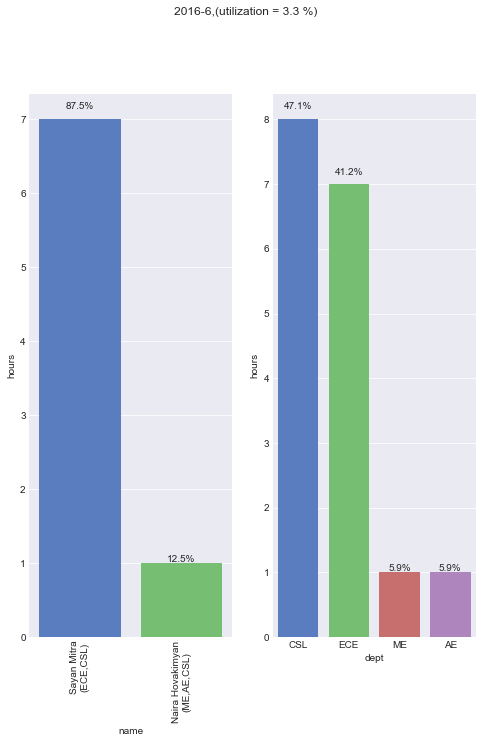

2016-7


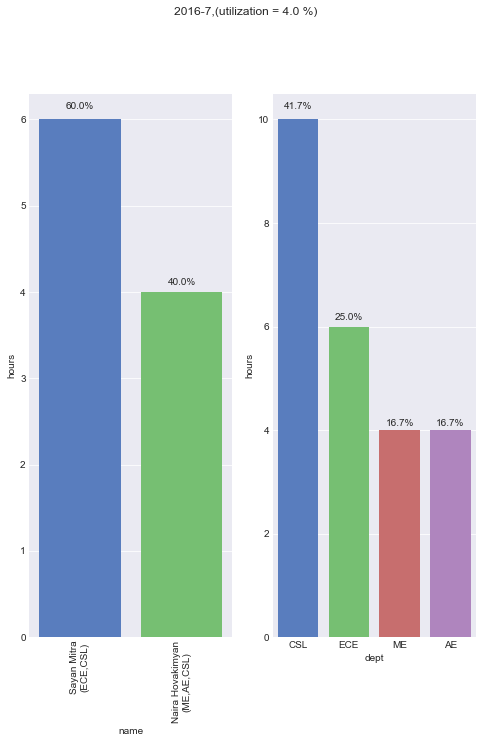

2016-8


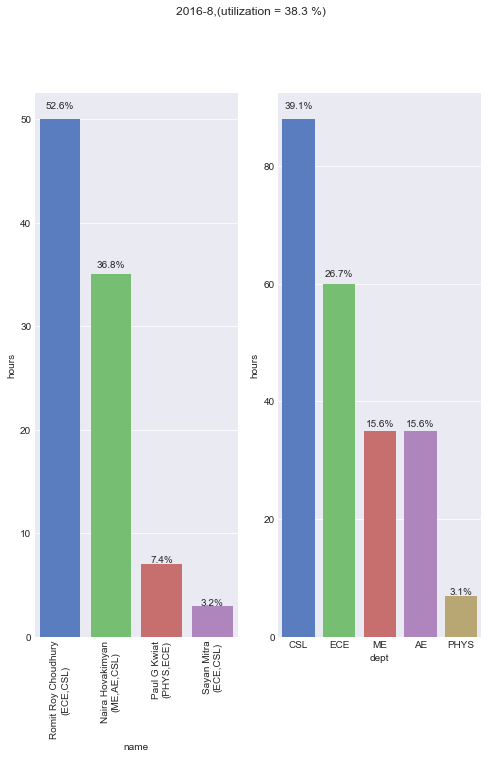

2016-9


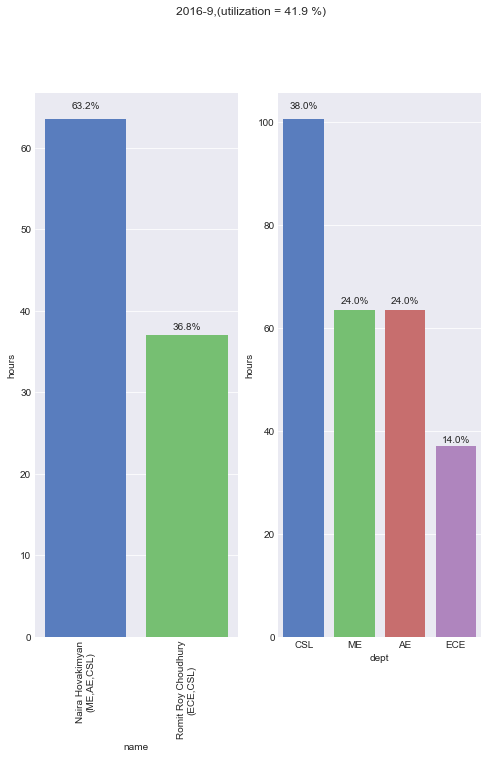

2016-10


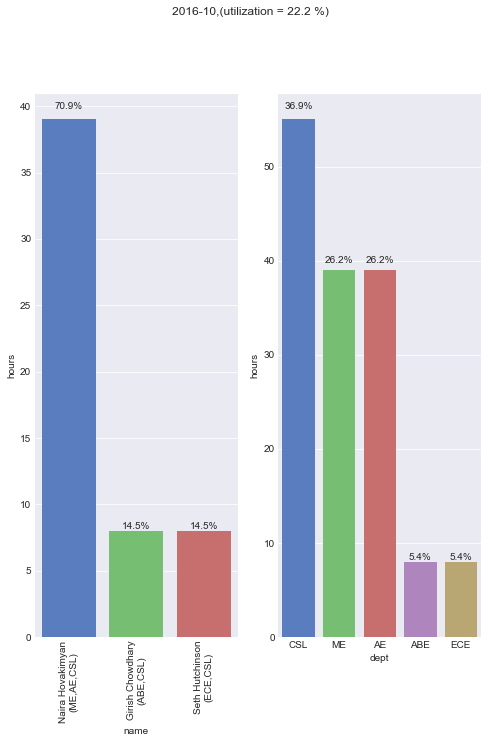

2016-11


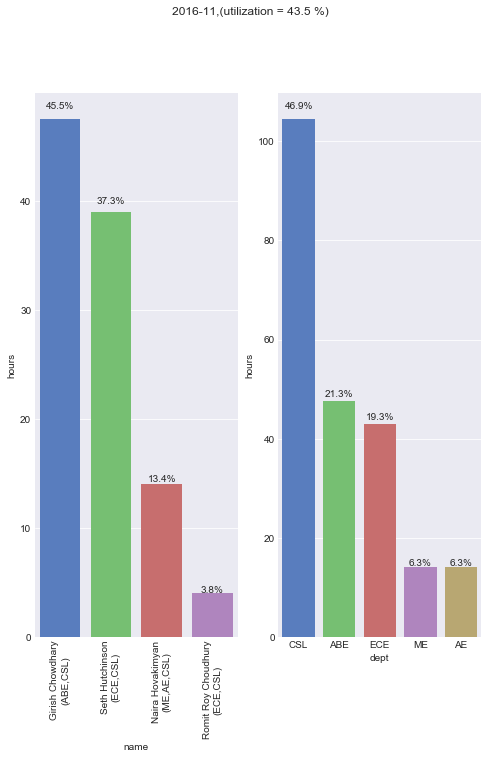

2016-12


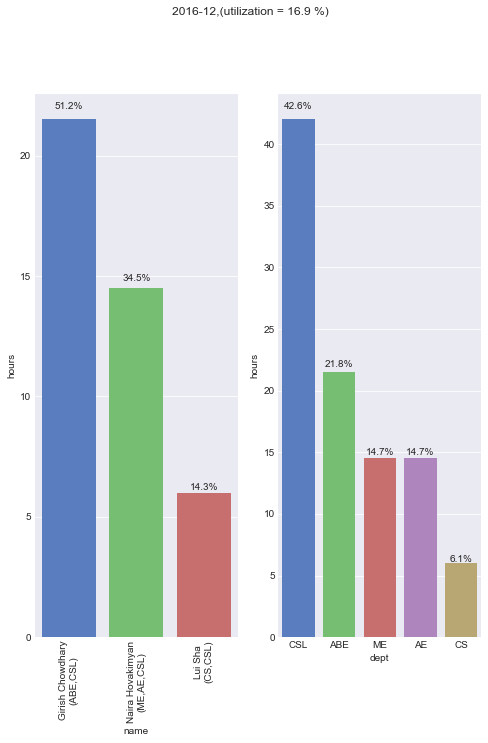

2017-1


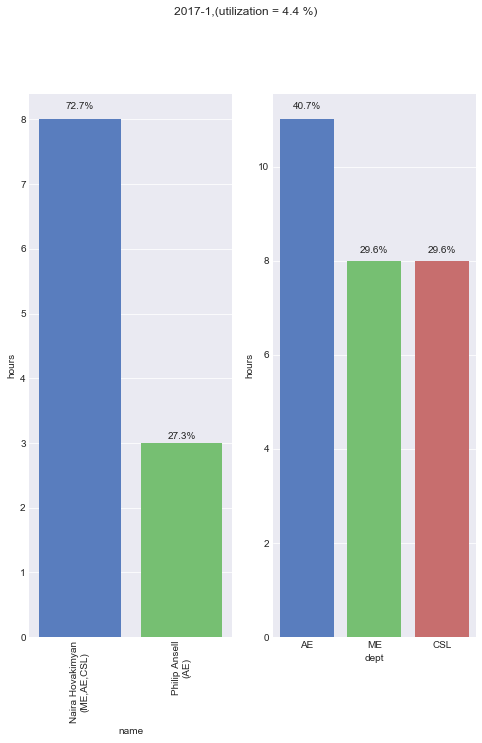

2017-2


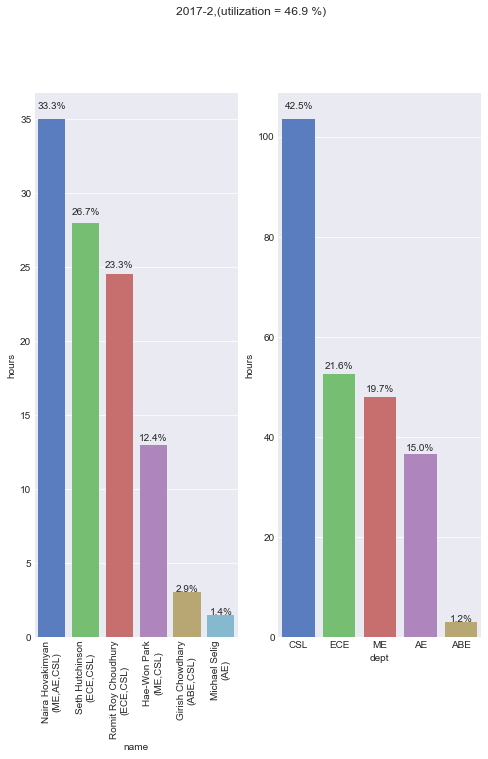

2017-3


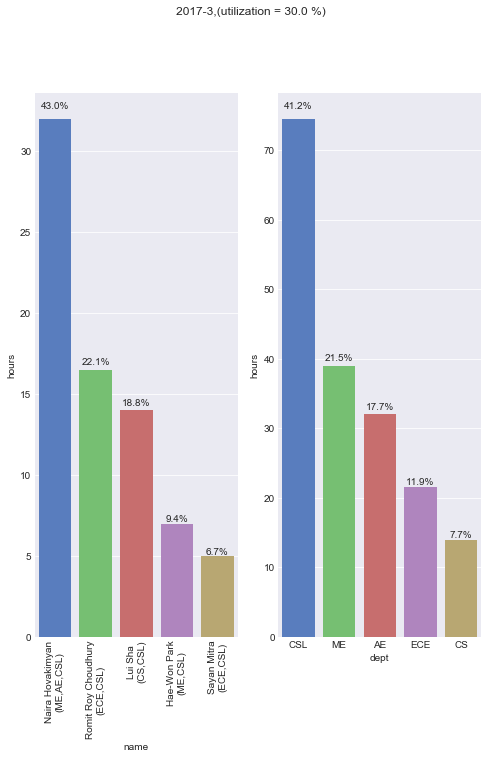

2017-4


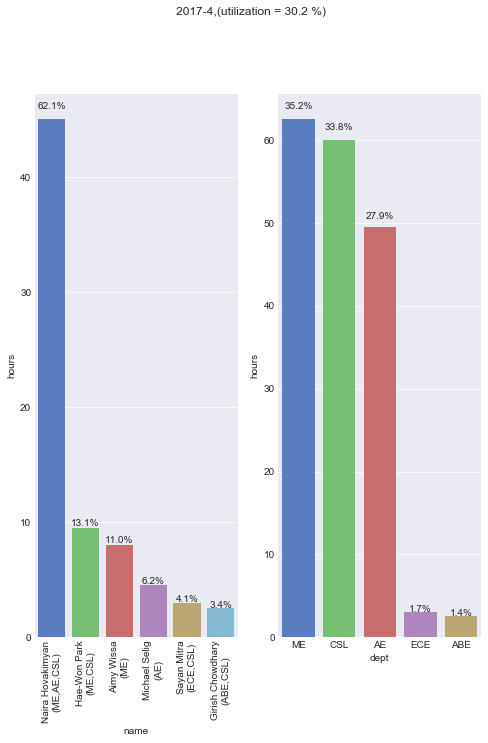

2017-5


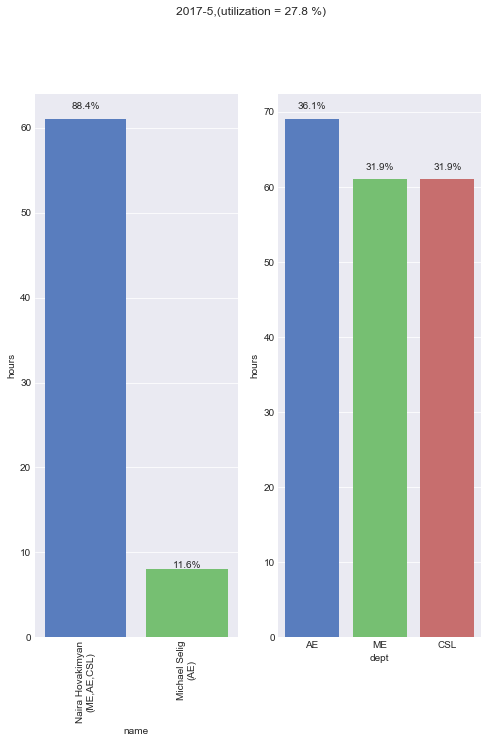

2017-6


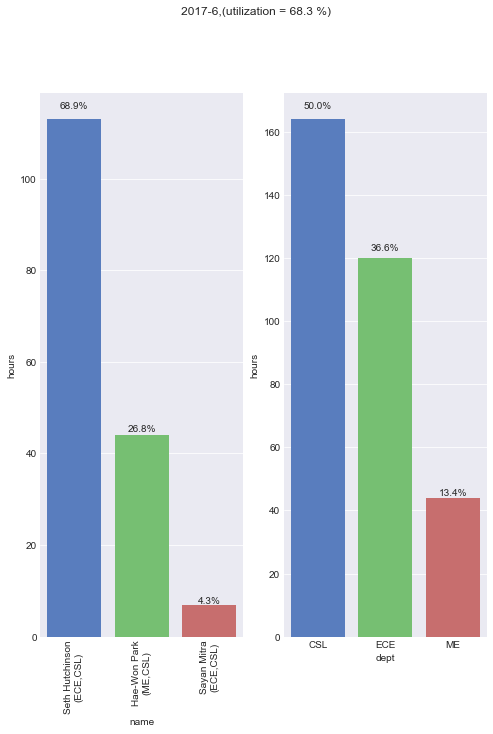

2017-7


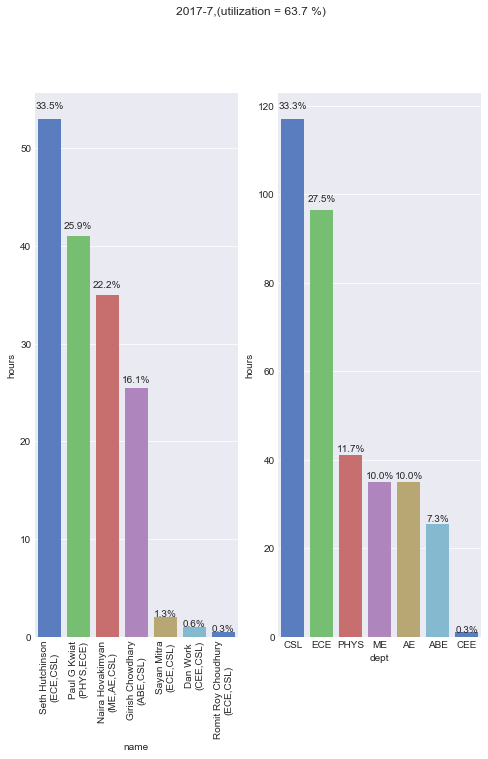

In [17]:
test = True
if test:
    for i in range(6,13):
        report_month(2016,i)

    for i in range(1,8):
        report_month(2017,i)